In [44]:
!pip install -q transformers datasets peft accelerate evaluate bitsandbytes
!pip install -q huggingface_hub

In [45]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [46]:
import torch

if torch.cuda.is_available():
    print("CUDA is available! GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Please ensure you have selected a GPU runtime.")

CUDA is available! GPU Name: Tesla T4


In [47]:
from google.colab import userdata

token = userdata.get('HF_TOKEN')

from huggingface_hub import login
login(token)

In [48]:
model_name = "EleutherAI/gpt-neo-125M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [49]:
tokenizer.pad_token = tokenizer.eos_token

In [50]:
model

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_fe

In [51]:
tokenizer

GPT2Tokenizer(name_or_path='EleutherAI/gpt-neo-125M', vocab_size=50257, model_max_length=2048, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, added_tokens_decoder={
	50256: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [52]:
device = 'cuda'
model = model.to(device)

In [53]:
def generate_text(prompt, max_length=100):

    model.eval()

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    with torch.no_grad():

        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,   # FIX 1
            max_length=max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id    # FIX 2
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [54]:
prompts = [
    "Symptoms of diabetes include",
    "what is the name of first surgeon dr in the world ?",
    "Treatment for hypertension is",
    "Patient has fever, cough, and chest pain. Diagnosis:",
    "What causes asthma?",
]

for prompt in prompts:

    print("PROMPT:", prompt)
    print("RESPONSE:", generate_text(prompt))
    print("-"*50)

PROMPT: Symptoms of diabetes include
RESPONSE: Symptoms of diabetes include hypoglycemia, hypoglycemia associated with elevated blood glucose levels and/or hypoglycemia associated with increased risk of developing diabetic complications. The prevalence of these complications is not well understood. The prevalence of diabetes-related complications has been reported to be about 10-20% in individuals with normal glucose tolerance and hyperglycemia. However, there is a wide range of reported incidence of diabetes-related complications in individuals with normal glucose tolerance, and some studies
--------------------------------------------------
PROMPT: what is the name of first surgeon dr in the world ?
RESPONSE: what is the name of first surgeon dr in the world?

I've been trying to get my head around this topic for some time now. I've got a lot of information on the subject but not much to go on. I've been looking at some posts on the topic but I haven't found anything useful yet. I ho

In [55]:
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


In [56]:
dataset["train"][0]

{'input': 'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?',
 'output': 'Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.',
 'instruction': 'Answer this question truthfully'}

In [57]:
def format_example(example):

    text = f"Instruction: {example['instruction']}\nQuestion: {example['input']}\nResponse: {example['output']}"

    return {"text": text}

formatted_dataset = dataset["train"].map(format_example)

print(formatted_dataset[0]["text"])

Instruction: Answer this question truthfully
Question: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
Response: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.


In [58]:
def tokenize_function(example):

    tokens = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

    # For causal language modeling, labels = input_ids
    tokens["labels"] = tokens["input_ids"].copy()

    return tokens


tokenized_dataset = formatted_dataset.map(
    tokenize_function,
    batched=True
)

print(tokenized_dataset[0].keys())

dict_keys(['input', 'output', 'instruction', 'text', 'input_ids', 'attention_mask', 'labels'])


In [59]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ["instruction", "input", "output", "text"]
)

print(tokenized_dataset)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 33955
})


In [60]:
print(tokenized_dataset[0])


{'input_ids': [6310, 2762, 25, 23998, 428, 1808, 3872, 2759, 198, 24361, 25, 1867, 318, 262, 2776, 1022, 845, 1877, 337, 70, 17, 10, 2974, 11, 350, 4221, 2974, 11, 290, 6488, 17, 10, 2974, 30, 198, 31077, 25, 9576, 1877, 337, 70, 17, 10, 2974, 6053, 284, 1877, 350, 4221, 2974, 543, 287, 1210, 2482, 287, 1877, 6488, 17, 10, 2974, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 

In [61]:
split_dataset = tokenized_dataset.train_test_split(test_size=0.1)

train_dataset = split_dataset["train"]
eval_dataset = split_dataset["test"]

print(len(train_dataset), len(eval_dataset))

30559 3396


In [62]:
from peft import LoraConfig, get_peft_model, TaskType

In [63]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

In [64]:
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 589,824 || all params: 125,788,416 || trainable%: 0.4689


In [65]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./gptneo-medical-lora/runs",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="tensorboard",
    learning_rate=2e-4,
    weight_decay=0.01,
    fp16=True,
    push_to_hub=False
)

In [66]:
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    processing_class=tokenizer
)

In [67]:
trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.


Epoch,Training Loss,Validation Loss
1,0.630402,0.639007
2,0.626198,0.626147
3,0.622281,0.622289


TrainOutput(global_step=11460, training_loss=0.6457867074803324, metrics={'train_runtime': 2708.4381, 'train_samples_per_second': 33.849, 'train_steps_per_second': 4.231, 'total_flos': 1.2056398112489472e+16, 'train_loss': 0.6457867074803324, 'epoch': 3.0})

In [68]:
base_model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125M"
).to(device)

base_model.eval()

print("Base model loaded")

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Base model loaded


In [69]:
import os

os.listdir("./gptneo-medical-lora/runs")

['checkpoint-11460', 'checkpoint-3820', 'checkpoint-7640', 'runs']

In [70]:
from transformers import AutoModelForCausalLM
from peft import PeftModel

# Load base model
lora_model = AutoModelForCausalLM.from_pretrained(
    "EleutherAI/gpt-neo-125M"
)

# Load LoRA adapter from latest checkpoint
lora_model = PeftModel.from_pretrained(
    lora_model,
    "./gptneo-medical-lora/runs/checkpoint-11460"
).to(device)

lora_model.eval()

print("LoRA model loaded successfully")

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

GPTNeoForCausalLM LOAD REPORT from: EleutherAI/gpt-neo-125M
Key                                                   | Status     |  | 
------------------------------------------------------+------------+--+-
transformer.h.{0...11}.attn.attention.masked_bias     | UNEXPECTED |  | 
transformer.h.{0, 2, 4, 6, 8, 10}.attn.attention.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


LoRA model loaded successfully


In [71]:
def generate_with_model(model, prompt, max_length=100):

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)

    with torch.no_grad():

        outputs = model.generate(
            inputs.input_ids,
            attention_mask=inputs.attention_mask,
            max_length=max_length,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)

In [72]:
def generate_clean_response(model, question):

    prompt = f"""Instruction: Answer this question truthfully
Question: {question}
Response:"""

    full_output = generate_with_model(model, prompt)

    answer = full_output.split("Response:")[-1].strip()

    return answer

In [73]:
question = "What causes diabetes?"

print("BASE:", generate_clean_response(base_model, question))
print("LORA:", generate_clean_response(lora_model, question))

BASE: Diabetes is a condition that is caused by the overproduction of glucose in the body. In the body, the body produces glucose through the conversion of glucose to a non-essential amino acid called glycogen. This amino acid is converted into a sugar molecule called glucose. The body uses the sugar molecule to generate energy and other compounds.

Question: Is it possible to have diabetes?
Answer: Diabetes is
LORA: Diabetes causes hypoglycemia.


In [74]:
question = "What causes asthma?"

prompt = f"""Instruction: Answer this question truthfully
Question: {question}
Response:"""

print("BASE MODEL:\n")
print(generate_with_model(base_model, prompt))

print("\n\nLORA MODEL:\n")
print(generate_with_model(lora_model, prompt))

BASE MODEL:

Instruction: Answer this question truthfully
Question: What causes asthma?
Response: The answer depends on the question
and the context. If you are looking for a response to a question
you may want to check the following:
- What causes asthma?
- What causes asthma?
- How do I know if I am at risk?
- How do I know if I am at risk?
- How do I know if I am at risk?
- What is


LORA MODEL:

Instruction: Answer this question truthfully
Question: What causes asthma?
Response: Asthma is caused by the presence of the IgE receptor on the surface of the cells of the airways, and the IgE receptor on the cells of the lungs. The IgE receptor is a receptor that mediates the interaction between the IgE receptor and the IgE molecule on the cell surface of the cells of the airways. The IgE receptor is expressed on the cells of the airways


In [75]:
merged_model = lora_model.merge_and_unload()


In [76]:
merged_model.save_pretrained("./gptneo-medical-lora-final")
tokenizer.save_pretrained("./gptneo-medical-lora-final")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

('./gptneo-medical-lora-final/tokenizer_config.json',
 './gptneo-medical-lora-final/tokenizer.json')

In [77]:
test_model = AutoModelForCausalLM.from_pretrained(
    "./gptneo-medical-lora-final"
).to(device)

test_model.eval()

print(generate_with_model(
    test_model,
"""Instruction: Answer this question truthfully
Question: What causes diabetes?
Response:"""))

Loading weights:   0%|          | 0/160 [00:00<?, ?it/s]

Instruction: Answer this question truthfully
Question: What causes diabetes?
Response: Diabetes causes insulin resistance.


In [78]:
# merged_model.push_to_hub("YousefBadr/gptneo-medical-lora")
# tokenizer.push_to_hub("YousefBadr/gptneo-medical-lora")

In [79]:
import math
eval_metrics = trainer.evaluate()
eval_loss = eval_metrics.get("eval_loss")
ppl = math.exp(eval_loss) if eval_loss is not None else None
print("Eval loss:", eval_loss)
print("Perplexity:", ppl)

Eval loss: 0.6222892999649048
Perplexity: 1.8631885606893763


In [80]:
import torch
import math
from tqdm import tqdm
def evaluate_perplexity(model, dataset):
    model.eval()
    total_loss = 0
    total_tokens = 0
    with torch.no_grad():
        for batch in tqdm(dataset):
            input_ids = torch.tensor(batch["input_ids"]).unsqueeze(0).to(device)
            attention_mask = torch.tensor(batch["attention_mask"]).unsqueeze(0).to(device)
            labels = torch.tensor(batch["labels"]).unsqueeze(0).to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            num_tokens = attention_mask.sum().item()
            total_loss += loss.item() * num_tokens
            total_tokens += num_tokens
    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)
    return avg_loss, perplexity

In [81]:
base_loss, base_ppl = evaluate_perplexity(base_model, eval_dataset)
lora_loss, lora_ppl = evaluate_perplexity(lora_model, eval_dataset)
merged_loss, merged_ppl = evaluate_perplexity(merged_model, eval_dataset)
print("Base model perplexity:", base_ppl)
print("Merged model perplexity:", merged_ppl)

100%|██████████| 3396/3396 [01:38<00:00, 34.65it/s]

Base model perplexity: 116.13023023683847
Merged model perplexity: 2.3436934676137793


Base model perplexity: 116.13023023683847
Merged model perplexity: 2.3436934676137793


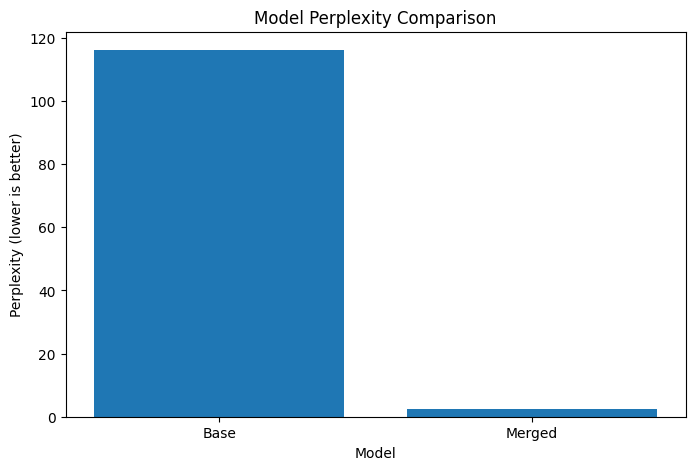

In [85]:
import matplotlib.pyplot as plt
print("Base model perplexity:", base_ppl)
print("Merged model perplexity:", merged_ppl)
models = ["Base", "Merged"]
perplexities = [base_ppl, lora_ppl]

plt.figure(figsize=(8,5))
plt.bar(models, perplexities)

plt.title("Model Perplexity Comparison")
plt.ylabel("Perplexity (lower is better)")
plt.xlabel("Model")

plt.show()

In [86]:
import torch
import math
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, dataset, model_name, max_samples=1000):

    model.eval()

    total_loss = 0
    total_tokens = 0

    # limit samples for faster evaluation
    dataset_subset = dataset.select(range(min(max_samples, len(dataset))))

    with torch.no_grad():

        for batch in tqdm(dataset_subset, desc=f"Evaluating {model_name}"):

            input_ids = torch.tensor(batch["input_ids"]).unsqueeze(0).to(device)
            attention_mask = torch.tensor(batch["attention_mask"]).unsqueeze(0).to(device)
            labels = torch.tensor(batch["labels"]).unsqueeze(0).to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss.item()
            tokens = attention_mask.sum().item()

            total_loss += loss * tokens
            total_tokens += tokens

    avg_loss = total_loss / total_tokens
    perplexity = math.exp(avg_loss)

    return {
        "Model": model_name,
        "Loss": round(avg_loss, 4),
        "Perplexity": round(perplexity, 4)
    }


# Evaluate all models
results = []

results.append(evaluate_model(base_model, eval_dataset, "Base GPT-Neo"))
results.append(evaluate_model(lora_model, eval_dataset, "GPT-Neo + LoRA"))
# results.append(evaluate_model(merged_model, eval_dataset, "GPT-Neo Merged"))

results_df = pd.DataFrame(results)

results_df

Evaluating GPT-Neo + LoRA: 100%|██████████| 1000/1000 [00:30<00:00, 33.29it/s]


,Model,Loss,Perplexity
0,Base GPT-Neo,4.7494,115.5108
1,GPT-Neo + LoRA,0.8638,2.3722


In [87]:
results_df.to_csv("model_performance_comparison.csv", index=False)

print("Results saved to model_performance_comparison.csv")

Results saved to model_performance_comparison.csv


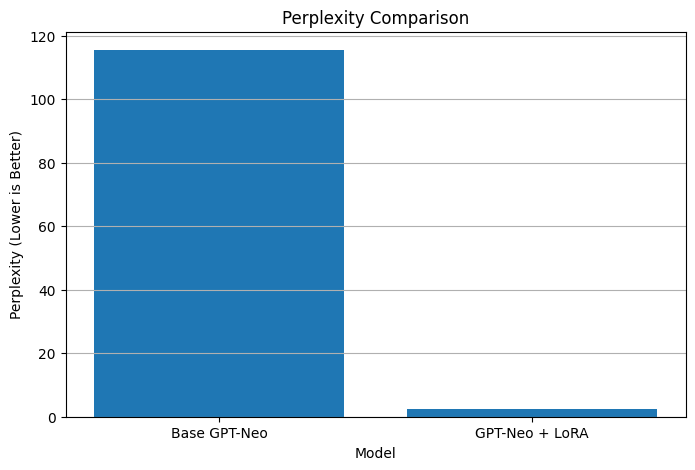

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))

plt.bar(results_df["Model"], results_df["Perplexity"])

plt.title("Perplexity Comparison")
plt.ylabel("Perplexity (Lower is Better)")
plt.xlabel("Model")

plt.grid(axis="y")

plt.savefig("perplexity_chart.png")

plt.show()

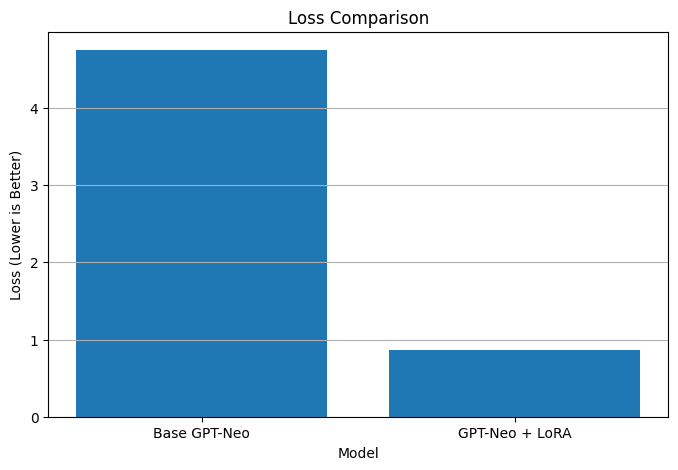

In [89]:
plt.figure(figsize=(8,5))

plt.bar(results_df["Model"], results_df["Loss"])

plt.title("Loss Comparison")
plt.ylabel("Loss (Lower is Better)")
plt.xlabel("Model")

plt.grid(axis="y")

plt.savefig("loss_chart.png")

plt.show()

In [90]:
questions = [
    "What causes diabetes?",
    "What is hypertension?",
    "What causes asthma?",
    "What is myocardial infarction?"
]

comparison_results = []

def generate_response(model, question):

    prompt = f"""Instruction: Answer this question truthfully
Question: {question}
Response:"""

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    outputs = model.generate(
        **inputs,
        max_length=200,
        temperature=0.7,
        top_p=0.9,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)


for q in questions:

    comparison_results.append({
        "Question": q,
        "Base Model": generate_response(base_model, q),
        "LoRA Model": generate_response(lora_model, q),
        # "Merged Model": generate_response(merged_model, q)
    })


comparison_df = pd.DataFrame(comparison_results)

comparison_df.to_csv("generation_comparison.csv", index=False)

comparison_df

,Question,Base Model,LoRA Model
0,What causes diabetes?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...
1,What is hypertension?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...
2,What causes asthma?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...
3,What is myocardial infarction?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...


In [91]:
base_ppl = results_df.loc[results_df["Model"]=="Base GPT-Neo", "Perplexity"].values[0]
lora_ppl = results_df.loc[results_df["Model"]=="GPT-Neo + LoRA", "Perplexity"].values[0]

improvement = ((base_ppl - lora_ppl) / base_ppl) * 100

print(f"Perplexity Improvement: {improvement:.2f}%")

Perplexity Improvement: 97.95%


In [92]:
comparison_df.head(2)

,Question,Base Model,LoRA Model
0,What causes diabetes?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...
1,What is hypertension?,Instruction: Answer this question truthfully\n...,Instruction: Answer this question truthfully\n...
